# Assignment 3
Feygelman Andrey

## Imports and helper functions

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numba import njit

In [2]:
from contextlib import contextmanager
import cProfile, pstats, io
from pstats import SortKey

@contextmanager
def profile():
    pr = cProfile.Profile()
    pr.enable()
    yield
    pr.disable()
    s = io.StringIO()
    sortby = SortKey.CUMULATIVE
    ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
    ps.print_stats()
    print(s.getvalue())

In [3]:
import json
with open('russia.json') as f:
    russia = json.load(f)
def draw_russia():
    # discard the Kaliningrad
    for e in russia[0]['geojson']['coordinates'][4:]:
        plt.plot(*list(zip(*e[0])), color = 'blue')

In [4]:
dataset = pd.read_csv('city/city.csv')

In [5]:
dataset

,address,postal_code,country,federal_district,region_type,region,area_type,area,city_type,city,...,fias_level,capital_marker,okato,oktmo,tax_office,timezone,geo_lat,geo_lon,population,foundation_year
0,"Респ Адыгея, г Адыгейск",385200.0,Россия,Южный,Респ,Адыгея,NaN,NaN,г,Адыгейск,...,4,0,79403000000,79703000001,107,UTC+3,44.878414,39.190289,12689,1969
1,г Майкоп,385000.0,Россия,Южный,Респ,Адыгея,NaN,NaN,г,Майкоп,...,4,2,79401000000,79701000001,105,UTC+3,44.609827,40.100661,144055,1857
2,г Горно-Алтайск,649000.0,Россия,Сибирский,Респ,Алтай,NaN,NaN,г,Горно-Алтайск,...,4,2,84401000000,84701000001,400,UTC+7,51.958103,85.960324,62861,1830
3,"Алтайский край, г Алейск",658125.0,Россия,Сибирский,край,Алтайский,NaN,NaN,г,Алейск,...,4,0,1403000000,1703000001,2201,UTC+7,52.492251,82.779361,28528,1913
4,г Барнаул,656000.0,Россия,Сибирский,край,Алтайский,NaN,NaN,г,Барнаул,...,4,2,1401000000,1701000001,2200,UTC+7,53.347997,83.779806,635585,1730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112,"Ярославская обл, г Ростов",152150.0,Россия,Центральный,обл,Ярославская,р-н,Ростовский,г,Ростов,...,4,1,78410000000,78637101001,7609,UTC+3,57.205132,39.437862,31791,862
1113,"Ярославская обл, г Рыбинск",152900.0,Россия,Центральный,обл,Ярославская,р-н,Рыбинский,г,Рыбинск,...,4,1,78415000000,78715000001,7610,UTC+3,58.048550,38.858412,200771,1071
1114,"Ярославская обл, г Тутаев",152300.0,Россия,Центральный,обл,Ярославская,р-н,Тутаевский,г,Тутаев,...,4,1,78417000000,78643101001,7611,UTC+3,57.867499,39.536963,41001,1200
1115,"Ярославская обл, г Углич",152610.0,Россия,Центральный,обл,Ярославская,р-н,Угличский,г,Углич,...,4,1,78420000000,78646101001,7612,UTC+3,57.522425,38.302004,34505,1148


In [6]:
from numpy import sin, cos, arccos, abs
from functools import lru_cache
N = len(dataset)

# I love when program spends 99% of its time inside pandas.read()! GOD BLESS PROFILER
lat = list(dataset['geo_lat'])
lon =  list(dataset['geo_lon'])
 
@lru_cache(maxsize = None)
def distance(i, j):
    # Returns distance in kilometres
    # using Great-circle distance formula from wikipedia
    f1 = lat[i]
    f2 = lat[j]
    l1 = lon[i]
    l2 = lon[j]
    angle = arccos(sin(f1)*sin(f2) + cos(f1)*cos(f2)*cos(abs(l1 - l2)))
    r = 6371
    return angle*r

In [7]:
distances = np.zeros((N,N), dtype = float)
# O(N^2), hell yea!
for i in range(N):
    for j in range(N):
        distances[i, j] = distance(i,j)

/tmp/ipykernel_304/2508226629.py:17: RuntimeWarning: invalid value encountered in arccos
  angle = arccos(sin(f1)*sin(f2) + cos(f1)*cos(f2)*cos(abs(l1 - l2)))


## Training function

In [8]:
@njit
def dist(path):
    # badass numba optimization
    # Turns out that build-in function sum() is just too slow ... bruh
    s = 0
    for i in range(N):
        s += distances[path[i], path[(i+1)%N]]
    return s

In [9]:
class Path:
    def __init__(self, l = None):
        if l is None: 
            self.path = list(range(N))
            np.random.shuffle(self.path)
        else: 
            self.path = l
        
        # glory to the profiler!
        if (not isinstance(self.path, np.ndarray)):
            self.path = np.array(self.path)
        
        self.dist = self._dist()
    
    def _dist(self):
        return dist(self.path)
    
    def energy(self, T):
        return np.exp(-self.dist/T)
    
    def propose(self):
        new_path = np.copy(self.path)
        i, j = np.random.randint(0, N-1), np.random.randint(0, N-1)
        new_path[i], new_path[j] = new_path[j], new_path[i]
        return Path(new_path)
    
    def next(self, T):
        proposal = self.propose()
        
        # equivalent of "a = np.exp((proposal.dist - self.dist)/T)"
        diff = self.dist - proposal.dist
        if (diff < 0):
            a = np.exp(diff/T) 
        else:
            a = 2
        
        if (np.random.random() <= a):
            return proposal
        else:
            return self

In [10]:
from tqdm import tqdm
class Train:
    def __init__(self, l=None, init_T = None, cooloing = 0.99, epochs = 100, cooling_by_final_T = None, use_tqdm = True):
        path = Path(l)
        if (init_T is None):
            init_T = path.dist
            
        if (cooling_by_final_T is not None):
            # this allows to adjust the cooloing geometric coefficient according to desired final temperature
            cooloing = np.exp(np.log(cooling_by_final_T/init_T) / epochs)
            print('cooloing geometric coefficient = ', cooloing)
        else:
            print('final_T = ', init_T * cooloing**epochs)
            pass
        
        T = init_T
        self.scores = []
#         self.energy = []
        self.temperature = []
        for _ in tqdm(list(range(epochs)), disable = not use_tqdm):
            self.scores.append(path.dist)
#             self.energy.append(path.energy(T))
            self.temperature.append(T)
            
            path = path.next(T)
            T = cooloing * T
        self.path = path

## Test different cooling speeds

In [11]:
very_slow = Train(cooling_by_final_T = 500, epochs = 10_000_000, init_T = 2_000_000)

cooloing geometric coefficient =  0.9999991705953799


100%|████████████████████████████████████████████████████████████████████| 10000000/10000000 [02:32<00:00, 65610.32it/s]


In [12]:
slow = Train(cooling_by_final_T = 100, epochs = 10_000_000, init_T = 2_000_000)

cooloing geometric coefficient =  0.9999990096517352


100%|████████████████████████████████████████████████████████████████████| 10000000/10000000 [02:39<00:00, 62574.68it/s]


In [13]:
middle_speed = Train(cooling_by_final_T = 0.1, epochs = 10_000_000, init_T = 2_000_000)

cooloing geometric coefficient =  0.99999831887713


100%|████████████████████████████████████████████████████████████████████| 10000000/10000000 [02:42<00:00, 61726.92it/s]


In [14]:
fast = Train(cooling_by_final_T = 0.001, epochs = 10_000_000, init_T = 2_000_000)

cooloing geometric coefficient =  0.9999978583609915


100%|████████████████████████████████████████████████████████████████████| 10000000/10000000 [02:47<00:00, 59566.94it/s]


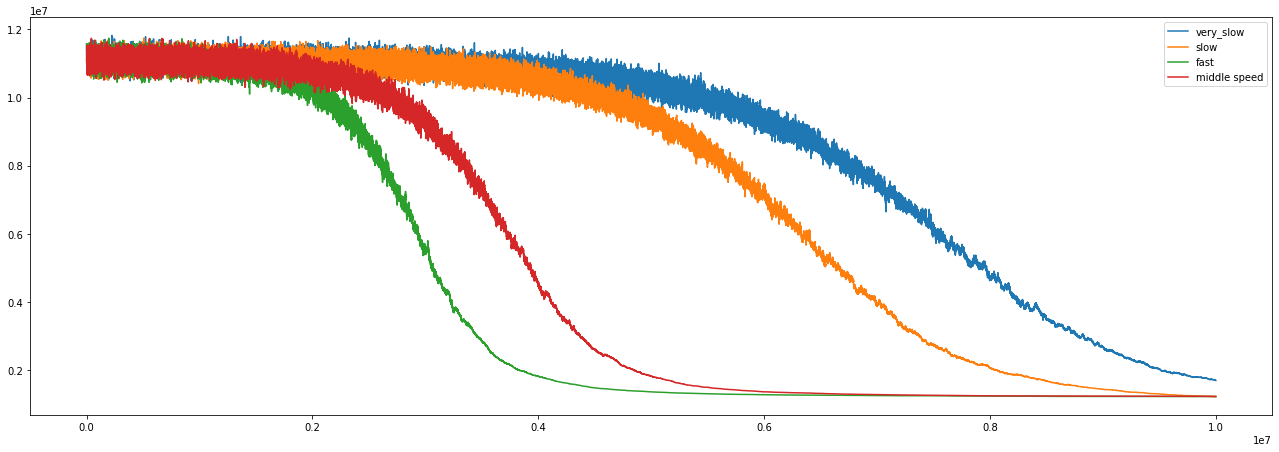

In [15]:
plt.subplots_adjust(right = 3, bottom = -0.5)
plt.plot(very_slow.scores, label = 'very_slow')
plt.plot(slow.scores, label = 'slow')
plt.plot(fast.scores, label = 'fast')
plt.plot(middle_speed.scores, label = 'middle speed')
# plt.yscale('log')
plt.legend()

In [16]:
names = ['very_slow', 'slow', 'middle', 'fast']
scores = [very_slow.scores[-1]/10**6, slow.scores[-1]/10**6, middle_speed.scores[-1]/10**6, fast.scores[-1]/10**6]
df = pd.DataFrame(data = {'names': names, 'total distance (in millions of km)': scores})
df

,names,total distance (in millions of km)
0,very_slow,1.695861
1,slow,1.216156
2,middle,1.227375
3,fast,1.221775


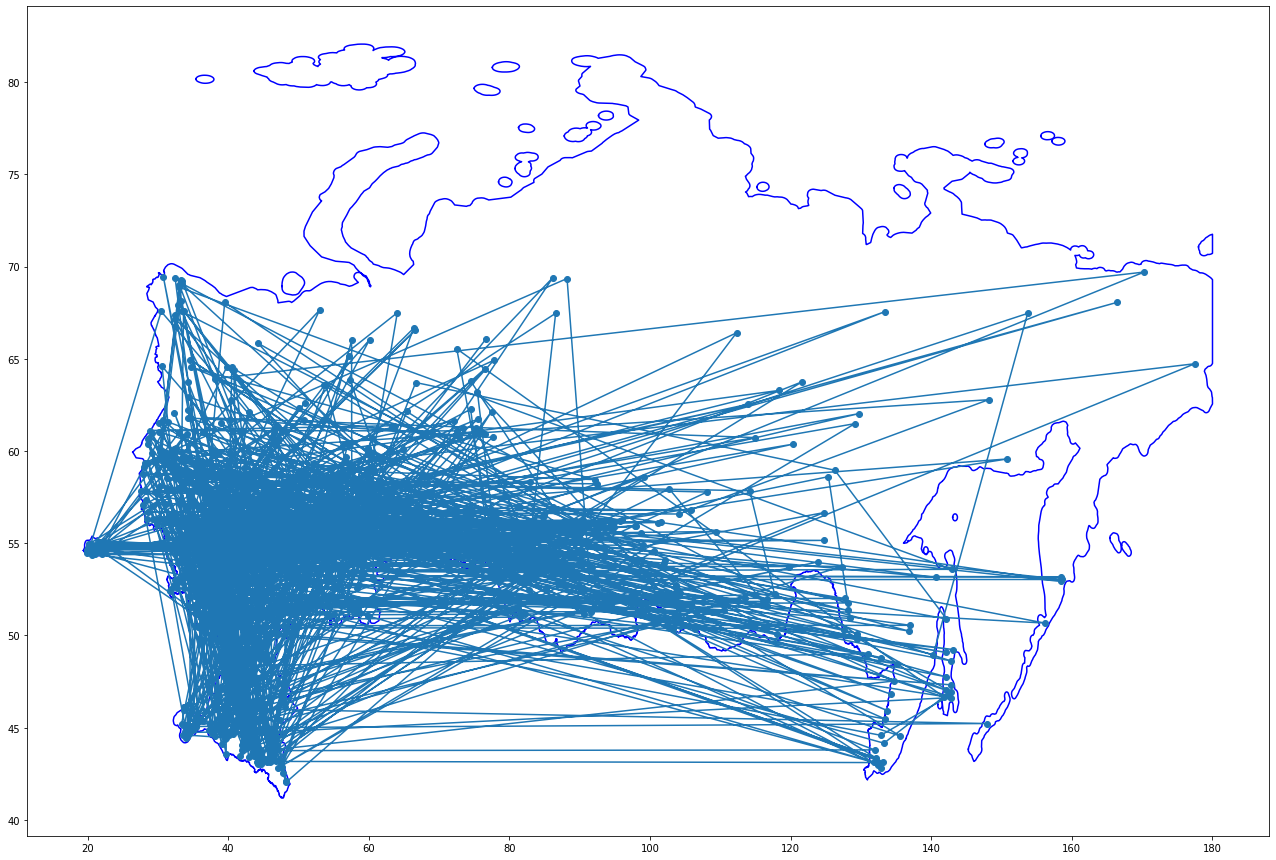

In [19]:
plt.subplots_adjust(right = 3, bottom = -2)
draw_russia()
plt.plot(dataset['geo_lon'][slow.path.path], dataset['geo_lat'][slow.path.path], '-o')

## Animation

In [55]:
%matplotlib inline

In [254]:
from tqdm import tqdm
def Train_Generator(l=None, init_T = None, cooloing = 0.99, epochs = 100, cooling_by_final_T = None, use_tqdm = False):
    path = Path(l)
    if (init_T is None):
        init_T = path.dist

    if (cooling_by_final_T is not None):
        # this allows to adjust the cooloing geometric coefficient according to desired final temperature
        cooloing = np.exp(np.log(cooling_by_final_T/init_T) / epochs)
        print('cooloing geometric coefficient = ', cooloing)
    else:
        print('final_T = ', init_T * cooloing**epochs)
        pass

    T = init_T
    for _ in tqdm(list(range(epochs)), disable = not use_tqdm):
        path = path.next(T)
        T = cooloing * T
        yield path.dist, T, path.path

In [255]:
epochs = 10_000_000
vid_length_in_sec = 120
fps = 20
frames = vid_length_in_sec * fps
take_each = int(epochs / frames)

In [256]:
gen = Train_Generator(cooling_by_final_T = 100, epochs = epochs, init_T = 2_000_000, use_tqdm = True)

100%|████████████████████████████████████████████████████████████████████▊| 9966268/10000000 [13:53<00:02, 11953.07it/s]


In [257]:
def take_each_gen(gen, take_each):
    for i,e in enumerate(gen):
        if i%take_each == 0:
            yield i, *e
            
gen = take_each_gen(gen, take_each)

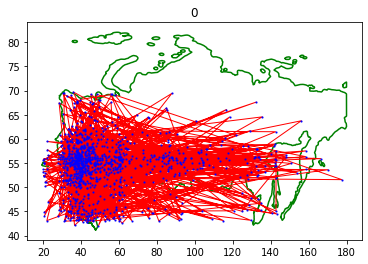

In [258]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
# %matplotlib notebook

fig, ax = plt.subplots()

for e in russia[0]['geojson']['coordinates'][4:]:
    ax.plot(*list(zip(*e[0])), color = 'green')

x = np.array(dataset['geo_lon'])
y = np.array(dataset['geo_lat'])
line, = ax.plot(x, y, '-', linewidth=1, color = 'red')
line2, = ax.plot(x, y, 's', linewidth=1, color = 'blue', markersize=1)
ax.set_title(0)


def animate(i):
    epoch, distance, T, path = next(gen)
    distance/= 10**6
    line.set_ydata(y[path])
    line.set_xdata(x[path])
    ax.set_title(f'{epoch = }; {distance = :.2f} mil km; {T = :.0f}')
    return line, 


# Init only required for blitting to give a clean slate.
def init():
#     line.set_ydata(np.ma.array(y, mask=True))
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(1, frames), init_func=init,
                              interval=25, blit=True)
# plt.show()

In [259]:
# writervideo = animation.PillowWriter(fps = fps)
# ani.save(r'./test3.gif', writer=writervideo, dpi = 100)

In [260]:
writervideo = animation.FFMpegWriter(fps = fps)
ani.save(r'./result.mp4', writer=writervideo, dpi = 400)

cooloing geometric coefficient =  0.9999990096517352


100%|████████████████████████████████████████████████████████████████████▉| 9988173/10000000 [15:44<00:01, 11038.99it/s]